<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

# Day 29 - Exercises Solutions

## 1)

Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [1]:
from Resources.Think_Stats.Thinkstats2 import brfss
import numpy as np

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [2]:
from Resources.Think_Stats.Thinkstats2 import thinkstats2

inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.993080416391812, 0.005281454169417809)

Make a scatter plot of the data and show the fitted line.

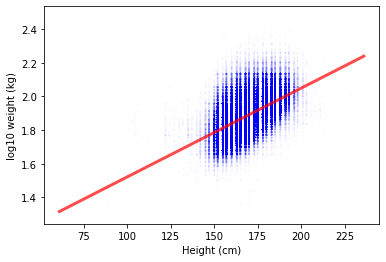

In [3]:
from Resources.Think_Stats.Thinkstats2 import thinkplot

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

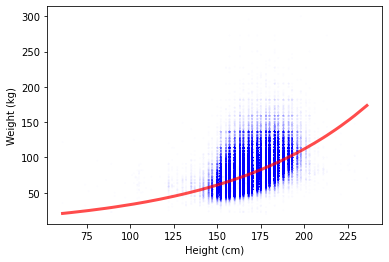

In [4]:
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

Plot percentiles of the residuals.

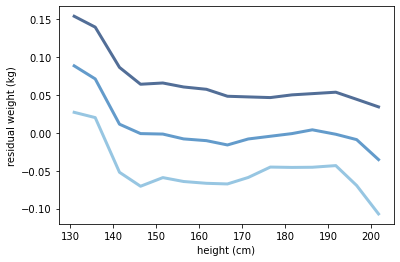

In [5]:
# The lines are flat over most of the range, 
# indicating that the relationship is linear.

# The lines are mostly parallel, indicating 
# that the variance of the residuals is the 
# same over the range.

res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

Compute correlation.

In [6]:
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983437

Compute coefficient of determination.

In [7]:
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311894054

Confirm that $R^2 = \rho^2$.

In [8]:
rho**2 - r2

-4.996003610813204e-16

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [9]:
std_ys = thinkstats2.Std(log_weights)
std_ys

0.103207250300049

Compute Std(res), the RMSE of predictions that do use height.

In [10]:
std_res = thinkstats2.Std(res)
std_res

0.0874077708041609

How much does height information reduce RMSE?

In [11]:
1 - std_res / std_ys

0.15308497658793452

Use resampling to compute sampling distributions for inter and slope.

In [12]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

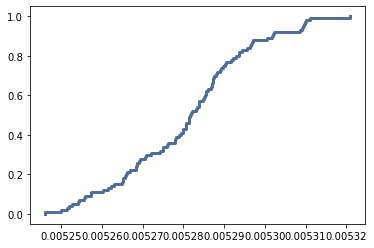

In [13]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [14]:
pvalue = cdf[0]
pvalue

0.0

Compute the 90% confidence interval of slope.

In [15]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.0052525612016430445, 0.0053093190324946206)

Compute the mean of the sampling distribution.

In [16]:
mean = thinkstats2.Mean(slopes)
mean

0.005280805722299851

Compute the standard deviation of the sampling distribution, which is the standard error.

In [17]:
stderr = thinkstats2.Std(slopes)
stderr

1.5866014259150986e-05

Resample rows without weights, compute mean height, and summarize results.

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.

In [18]:
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Here's  the summary for `inter`.

In [19]:
Summarize(inters)

mean, SE, CI 0.9932085827909916 0.0027104190789020367 (0.988284696988888, 0.9980005687787045)


And for `slope`.

In [20]:
Summarize(slopes)

mean, SE, CI 0.005280805722299851 1.5866014259150986e-05 (0.0052525612016430445, 0.0053093190324946206)


In [21]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95984485842476 0.01764847990214139 (168.92896733967947, 168.98799995957881)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [23]:
# The estimated mean height is almost 2 cm taller 
# if we take into account the sampling weights,
# and this difference is much bigger than the sampling error.

estimates_weighted = [thinkstats2.ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.49339439459166 0.01347689260756209 (170.46929505446755, 170.51558742092604)
